In [35]:
from src.data_io import ImageData
from cv2 import imread
import os
import glob
import numpy as np
import torch
from skimage import transform, io
from matplotlib import pyplot as plt

import monai
import torch.nn as nn

from medsam import medsam_inference, show_box, show_mask, preprocess, visualize_results
from segment_anything import sam_model_registry

In [4]:
img_path = 'data/medsam_data/CXR_png'
mask_path = 'data/medsam_data/masks'
num_files=10

img_files = sorted(glob.glob(os.path.join(img_path, '*')))[:num_files]
mask_files = sorted(glob.glob(os.path.join(mask_path, '*')))[:num_files]

print(f"Files in '{img_path}':")
for img_file in img_files:
    print(img_file)

Files in 'data/medsam_data/CXR_png':
data/medsam_data/CXR_png/CHNCXR_0001_0.png
data/medsam_data/CXR_png/CHNCXR_0002_0.png
data/medsam_data/CXR_png/CHNCXR_0003_0.png
data/medsam_data/CXR_png/CHNCXR_0004_0.png
data/medsam_data/CXR_png/CHNCXR_0005_0.png
data/medsam_data/CXR_png/CHNCXR_0006_0.png
data/medsam_data/CXR_png/CHNCXR_0007_0.png
data/medsam_data/CXR_png/CHNCXR_0008_0.png
data/medsam_data/CXR_png/CHNCXR_0009_0.png
data/medsam_data/CXR_png/CHNCXR_0010_0.png


In [5]:
raw_images = [imread(f) for f in img_files]
raw_masks = [imread(f) for f in mask_files]

print("Image original shape", raw_images[0].shape)
print("Mask original shape", raw_masks[0].shape)

raw_masks = [mask[:, :, 0] for mask in raw_masks]
print("Mask final shape", raw_masks[0].shape)


Image original shape (2919, 3000, 3)
Mask original shape (2919, 3000, 3)
Mask final shape (2919, 3000)


In [6]:
mask_matrix = np.array(raw_masks[0])
unique_values = np.unique(mask_matrix)
print("Unique values in the segmentation mask:", unique_values)

Unique values in the segmentation mask: [  0 255]


In [7]:
images = ImageData(raw=raw_images,
                    batch_size=8,
                    image_ids=[i for i in range(num_files)],
                    masks=raw_masks,
                    predicted_masks=raw_masks)

In [ ]:
def get_bounding_box(mask):
    """
    Calculate the bounding box from the ground truth mask.
    
    Args:
        mask (numpy.ndarray): Ground truth mask with shape (H, W).
        
    Returns:
        str: Bounding box in the format "[x_min, y_min, x_max, y_max]".
    """
    rows, cols = np.where(mask > 0)
    
    y_min, y_max = rows.min(), rows.max()
    x_min, x_max = cols.min(), cols.max()
    
    return f"[{x_min},{y_min},{x_max},{y_max}]"

In [11]:
# preprocessing
# ImageData input: (H, W, C)
# desired input for MedSAM: (B, C, H, W), where H=W=1024
MedSAM_CKPT_PATH = 'work_dir/MEDSAM/medsam_vit_b.pth'
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
print("found medsam model")
medsam_model.eval()

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_locati

found medsam model


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


type <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape (2919, 3000) (2919, 3000)
seg_loss 0.3753964304924011, ce_loss 0.6084285974502563, total_loss 0.9838250279426575


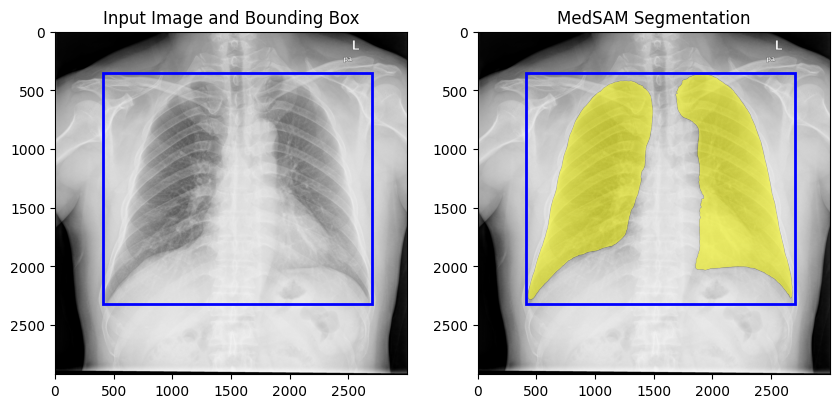

In [ ]:
num_files = 1
device = "cpu"
all_masks = []
for img_np, mask_np in zip(images.raw[:num_files], images.masks[:num_files]):
    box = get_bounding_box(mask_np)
    image_embedding, box_1024, H, W, img_3c, box_np = preprocess(medsam_model, img_np, box, device)
    medsam_pred = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
    # ce_loss = nn.BCEWithLogitsLoss(reduction="mean")

    pred = torch.tensor(medsam_pred, dtype=torch.float32)
    gt = torch.tensor(mask_np / 255.0, dtype=torch.float32)
    
    l1 = seg_loss(pred, gt)
    # l2 = ce_loss(pred, gt)
    loss = l1   # loss = l1 + l2
    print(f"seg_loss {l1}")

    all_masks.append(medsam_pred)
    visualize_results(img_3c, box_np, medsam_pred)